# Router Chain Example

![1 A2M2OqVP-s6aA9IqDcgaRQ.webp](<attachment:1 A2M2OqVP-s6aA9IqDcgaRQ.webp>)

参考：
1. https://medium.com/@gil.fernandes/langchains-router-chains-and-callbacks-722524c4aa42
2. https://github.com/gilfernandes/router_chain_playground/blob/main/lang_chain_router_chain.py


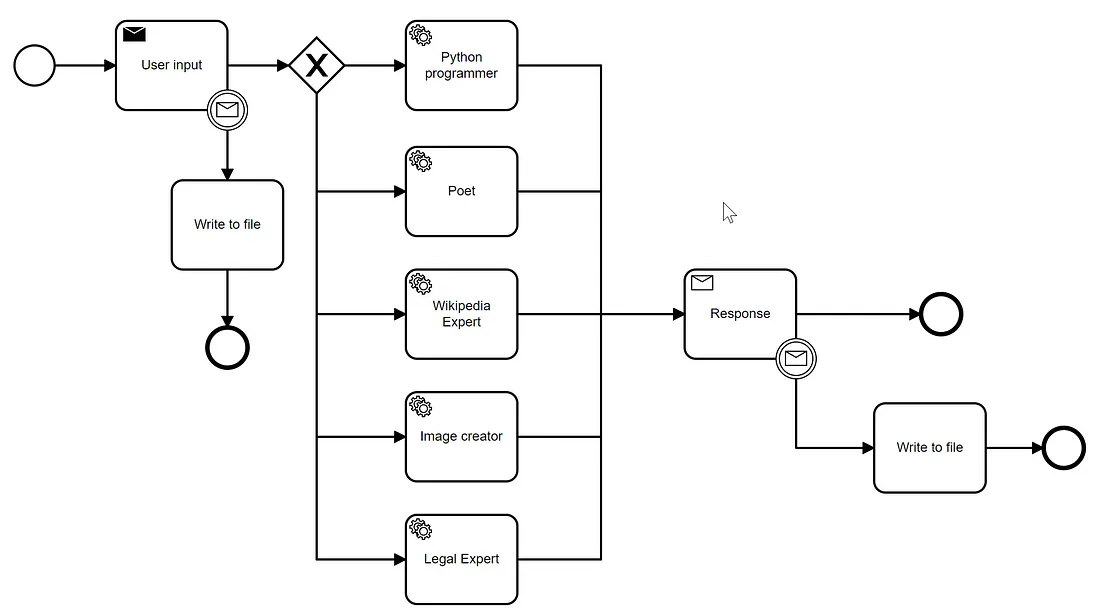

In [1]:
import os

# 初始化
API_KEY = os.getenv("UNION_API_KEY")
BASE_URL = os.getenv("UNION_BASE_URL")

In [12]:
from langchain.chains.router import MultiPromptChain
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate

from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE

from prompt_toolkit import HTML, prompt
import langchain.callbacks

langchain.callbacks.StdOutCallbackHandler

from langchain.callbacks import FileCallbackHandler

from pathlib import Path

file_ballback_handler = FileCallbackHandler(Path('router_chain.txt'))

class Config(): 
    model = 'gpt-3.5-turbo-0613'
    llm = ChatOpenAI(model=model, temperature=0, api_key=API_KEY, base_url=BASE_URL, callbacks=[file_ballback_handler])

cfg = Config()

# 提示词工厂类，为不同的场景生成不同的提示词
class PromptFactory():
    # 编码场景：developer
    developer_template = """You are a very smart Python programmer. \
    You provide answers for algorithmic and computer problems in Python. \
    You explain the code in a detailed manner. \

    Here is a question:
    {input}"""

    # 诗歌创作场景：poet
    poet_template = """You are a poet who replies to creative requests with poems in English. \
    You provide answers which are poems in the style of Lord Byron or Shakespeare. \

    Here is a question:
    {input}"""

    # 维基百科知识问答场景：Wikipedia expert
    wiki_template = """You are a Wikipedia expert. \
    You answer common knowledge questions based on Wikipedia knowledge. \
    Your explanations are detailed and in plain English.

    Here is a question:
    {input}"""

    # 图像创作场景：image creator
    image_creator_template = """You create a creator of images. \
    You provide graphic representations of answers using SVG images.

    Here is a question:
    {input}"""

    # 法律专家场景：legal expert
    legal_expert_template = """You are a UK or US legal expert. \
    You explain questions related to the UK or US legal systems in an accessible language \
    with a good number of examples.

    Here is a question:
    {input}"""


    # 所有场景的提示词信息
    prompt_infos = [
        {
            'name': 'python programmer',
            'description': 'Good for questions about coding and algorithms',
            'prompt_template': developer_template
        },
        {
            'name': 'poet',
            'description': 'Good for generating poems for creative questions',
            'prompt_template': poet_template
        },
        {
            'name': 'wikipedia expert',
            'description': 'Good for answering questions about general knowledge',
            'prompt_template': wiki_template
        },
        {
            'name': 'graphical artist',
            'description': 'Good for answering questions which require an image output',
            'prompt_template': image_creator_template
        },
        {
            'name': 'legal expert',
            'description': 'Good for answering questions which are related to UK or US law',
            'prompt_template': legal_expert_template
        }
    ]



def generate_destination_chains():
    """
    Creates a list of LLM chains with different prompt templates.
    """
    prompt_factory = PromptFactory()
    destination_chains = {}

    # 为每一个提示词创建一个LLM链
    for p_info in prompt_factory.prompt_infos:
        name = p_info['name']
        prompt_template = p_info['prompt_template']
        chain = LLMChain(
            llm=cfg.llm, 
            prompt=PromptTemplate(template=prompt_template, input_variables=['input']))
        destination_chains[name] = chain

    # 创建一个默认的对话链
    default_chain = ConversationChain(llm=cfg.llm, output_key="text")
    return prompt_factory.prompt_infos, destination_chains, default_chain


def generate_router_chain(prompt_infos, destination_chains, default_chain):
    """
    Generats the router chains from the prompt infos.
    :param prompt_infos The prompt informations generated above.
    """
    destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
    destinations_str = '\n'.join(destinations)

    # 使用Langchain的MULTI_PROMPT_ROUTER_TEMPLATE来生成路由器模板
    router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(destinations=destinations_str)
    router_prompt = PromptTemplate(
        template=router_template,
        input_variables=['input'],
        output_parser=RouterOutputParser()
    )

    # 定义Router Chain
    router_chain = LLMRouterChain.from_llm(cfg.llm, router_prompt)

    return MultiPromptChain(
        router_chain=router_chain,
        destination_chains=destination_chains,
        default_chain=default_chain,
        verbose=True,
        callbacks=[file_ballback_handler]
    )
    

In [13]:
prompt_infos, destination_chains, default_chain = generate_destination_chains()
chain = generate_router_chain(prompt_infos, destination_chains, default_chain)
while True:
    question = prompt(
        HTML("<b>Type <u>Your question</u></b>  ('q' to exit, 's' to save to html file): ")
    )
    if question == 'q':
        break
    if question == 's':
        file_ballback_handler.create_html()
        continue
    result = chain.run(question)
    print(result)
    print()

NoConsoleScreenBufferError: Found xterm-color, while expecting a Windows console. Maybe try to run this program using "winpty" or run it in cmd.exe instead. Or otherwise, in case of Cygwin, use the Python executable that is compiled for Cygwin.